### Introduction to Deep Learning - CS672 - 71942 - Fall 2025 - Project 2

### Group 04
### Team Members - Shergill Sajan (Singh), Dixit Ruturaj Makarand, Maniyar Krishna Kirit, Pipaliya Ronak Maheshbhai

In [ ]:
!pip install meteostat --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from meteostat import Point, Daily

import seaborn as sns


from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

pd.set_option("display.max_columns", 60)
print("TensorFlow:", tf.__version__)


TensorFlow: 2.19.0


## Data Load

In [ ]:
# --- NYC Yellow Taxi data: January 2020 ---
TAXI_URL = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-01.parquet"

print("Loading taxi data from:", TAXI_URL)
taxi_df = pd.read_parquet(TAXI_URL)
print("Taxi shape:", taxi_df.shape)
display(taxi_df.head())

# --- NYC Weather data via Meteostat API (Wall Street) ---
nyc_point = Point(40.7060, -74.0086)

start = datetime(2020, 1, 1)
end   = datetime(2020, 1, 31)

weather_jan = Daily(nyc_point, start=start, end=end).fetch()
weather_df = weather_jan.reset_index().rename(columns={"time": "date"})

print("Weather (Jan 2020) shape:", weather_df.shape)
display(weather_df.head())


Loading taxi data from: https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-01.parquet
Taxi shape: (6405008, 19)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2020-01-01 00:28:15,2020-01-01 00:33:03,1.0,1.2,1.0,N,238,239,1,6.0,3.0,0.5,1.47,0.0,0.3,11.27,2.5,None
1,1,2020-01-01 00:35:39,2020-01-01 00:43:04,1.0,1.2,1.0,N,239,238,1,7.0,3.0,0.5,1.50,0.0,0.3,12.30,2.5,None
2,1,2020-01-01 00:47:41,2020-01-01 00:53:52,1.0,0.6,1.0,N,238,238,1,6.0,3.0,0.5,1.00,0.0,0.3,10.80,2.5,None
3,1,2020-01-01 00:55:23,2020-01-01 01:00:14,1.0,0.8,1.0,N,238,151,1,5.5,0.5,0.5,1.36,0.0,0.3,8.16,0.0,None
4,2,2020-01-01 00:01:58,2020-01-01 00:04:16,1.0,0.0,1.0,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80,0.0,None


Weather (Jan 2020) shape: (31, 11)


,date,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,2020-01-01,3.6,1.7,5.0,0.0,0.0,<NA>,17.3,<NA>,1008.2,<NA>
1,2020-01-02,4.7,0.6,8.9,0.0,0.0,<NA>,12.4,<NA>,1013.9,<NA>
2,2020-01-03,7.6,6.7,8.3,2.8,0.0,<NA>,8.4,<NA>,1010.2,<NA>
3,2020-01-04,8.2,6.7,9.4,5.3,0.0,<NA>,5.7,<NA>,1003.7,<NA>
4,2020-01-05,4.6,2.8,7.2,0.0,0.0,<NA>,8.2,<NA>,1010.1,<NA>


### Data Cleaning & Feature Engineering


In [ ]:
df = taxi_df.copy()

# Ensure datetime
df["tpep_pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"])
df["tpep_dropoff_datetime"] = pd.to_datetime(df["tpep_dropoff_datetime"])

# Trip duration in minutes (target)
df["trip_duration_min"] = (
    df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]
).dt.total_seconds() / 60.0

# Basic trip filters
df = df[
    (df["trip_duration_min"] > 1) &
    (df["trip_duration_min"] <= 180) &
    (df["trip_distance"] > 0) &
    (df["trip_distance"] <= 50)
].copy()

df = df.dropna(subset=["trip_distance", "trip_duration_min"])

# Time features
df["pickup_hour"] = df["tpep_pickup_datetime"].dt.hour
df["pickup_weekday"] = df["tpep_pickup_datetime"].dt.weekday
df["is_weekend"] = df["pickup_weekday"].isin([5, 6]).astype(int)
df["is_rush_hour"] = df["pickup_hour"].isin([7, 8, 9, 16, 17, 18, 19]).astype(int)

# For merging with weather
df["pickup_date"] = df["tpep_pickup_datetime"].dt.normalize()

print("Cleaned taxi shape:", df.shape)
display(df.head())


Cleaned taxi shape: (6294171, 25)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration_min,pickup_hour,pickup_weekday,is_weekend,is_rush_hour,pickup_date
0,1,2020-01-01 00:28:15,2020-01-01 00:33:03,1.0,1.2,1.0,N,238,239,1,6.0,3.0,0.5,1.47,0.0,0.3,11.27,2.5,None,4.800000,0,2,0,0,2020-01-01
1,1,2020-01-01 00:35:39,2020-01-01 00:43:04,1.0,1.2,1.0,N,239,238,1,7.0,3.0,0.5,1.50,0.0,0.3,12.30,2.5,None,7.416667,0,2,0,0,2020-01-01
2,1,2020-01-01 00:47:41,2020-01-01 00:53:52,1.0,0.6,1.0,N,238,238,1,6.0,3.0,0.5,1.00,0.0,0.3,10.80,2.5,None,6.183333,0,2,0,0,2020-01-01
3,1,2020-01-01 00:55:23,2020-01-01 01:00:14,1.0,0.8,1.0,N,238,151,1,5.5,0.5,0.5,1.36,0.0,0.3,8.16,0.0,None,4.850000,0,2,0,0,2020-01-01
9,1,2020-01-01 00:29:01,2020-01-01 00:40:28,2.0,0.7,1.0,N,246,48,1,8.0,3.0,0.5,2.35,0.0,0.3,14.15,2.5,None,11.450000,0,2,0,0,2020-01-01


##Merging Taxi Trip Data with Weather Information

In [ ]:
w = weather_df.copy()
w["date"] = pd.to_datetime(w["date"])
w = w.sort_values("date").copy()
w = w.interpolate(method="linear", limit_direction="both").copy()

merged_df = df.merge(
    w,
    left_on="pickup_date",
    right_on="date",
    how="left"
).copy()

merged_df.drop(columns=["date"], inplace=True, errors="ignore")

print("Merged_df shape:", merged_df.shape)
display(merged_df.head())


Merged_df shape: (6294171, 35)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration_min,pickup_hour,pickup_weekday,is_weekend,is_rush_hour,pickup_date,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,1,2020-01-01 00:28:15,2020-01-01 00:33:03,1.0,1.2,1.0,N,238,239,1,6.0,3.0,0.5,1.47,0.0,0.3,11.27,2.5,None,4.800000,0,2,0,0,2020-01-01,3.6,1.7,5.0,0.0,0.0,<NA>,17.3,<NA>,1008.2,<NA>
1,1,2020-01-01 00:35:39,2020-01-01 00:43:04,1.0,1.2,1.0,N,239,238,1,7.0,3.0,0.5,1.50,0.0,0.3,12.30,2.5,None,7.416667,0,2,0,0,2020-01-01,3.6,1.7,5.0,0.0,0.0,<NA>,17.3,<NA>,1008.2,<NA>
2,1,2020-01-01 00:47:41,2020-01-01 00:53:52,1.0,0.6,1.0,N,238,238,1,6.0,3.0,0.5,1.00,0.0,0.3,10.80,2.5,None,6.183333,0,2,0,0,2020-01-01,3.6,1.7,5.0,0.0,0.0,<NA>,17.3,<NA>,1008.2,<NA>
3,1,2020-01-01 00:55:23,2020-01-01 01:00:14,1.0,0.8,1.0,N,238,151,1,5.5,0.5,0.5,1.36,0.0,0.3,8.16,0.0,None,4.850000,0,2,0,0,2020-01-01,3.6,1.7,5.0,0.0,0.0,<NA>,17.3,<NA>,1008.2,<NA>
4,1,2020-01-01 00:29:01,2020-01-01 00:40:28,2.0,0.7,1.0,N,246,48,1,8.0,3.0,0.5,2.35,0.0,0.3,14.15,2.5,None,11.450000,0,2,0,0,2020-01-01,3.6,1.7,5.0,0.0,0.0,<NA>,17.3,<NA>,1008.2,<NA>


##Feature Engineering – Creating Derived & Weather-Enhanced Features

In [ ]:
# avg_mph: safe computation
avg_mph = merged_df["trip_distance"] / (merged_df["trip_duration_min"] / 60.0)
avg_mph = avg_mph.replace([np.inf, -np.inf], np.nan)

if avg_mph.notna().any():
    avg_mph = avg_mph.fillna(avg_mph.median())
else:
    avg_mph = avg_mph.fillna(0.0)

merged_df["avg_mph"] = avg_mph

# Base features
feature_cols = [
    "passenger_count",
    "trip_distance",
    "fare_amount",
    "tip_amount",
    "pickup_hour",
    "pickup_weekday",
    "is_weekend",
    "is_rush_hour",
    "avg_mph",
]

# Add weather features if present
weather_feature_candidates = ["tavg", "tmin", "tmax", "prcp", "snow", "wdir", "wspd", "pres", "tsun"]
for col in weather_feature_candidates:
    if col in merged_df.columns:
        feature_cols.append(col)

print("Using features:", feature_cols)


Using features: ['passenger_count', 'trip_distance', 'fare_amount', 'tip_amount', 'pickup_hour', 'pickup_weekday', 'is_weekend', 'is_rush_hour', 'avg_mph', 'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'pres', 'tsun']


##Heatmap

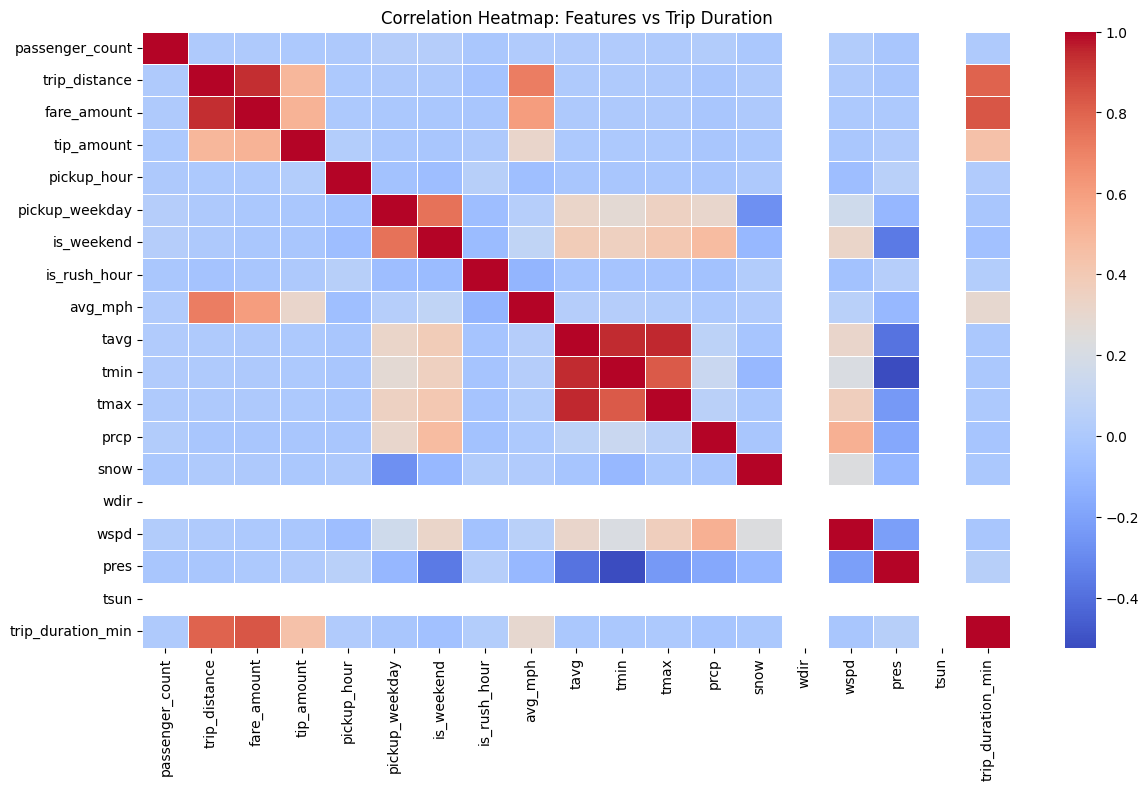

In [ ]:

plt.figure(figsize=(14,8))
corr_matrix = merged_df[feature_cols + ["trip_duration_min"]].corr()
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap: Features vs Trip Duration")
plt.show()


##Trip Duration on Rainy vs Clear Days

Columns now: ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee', 'trip_duration_min', 'pickup_hour', 'pickup_weekday', 'is_weekend', 'is_rush_hour', 'pickup_date', 'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun', 'avg_mph', 'temp_bucket', 'rainy']
   prcp  rainy
0   0.0      0
1   0.5      1
2   5.3      1
3   0.0      0
4   0.0      0


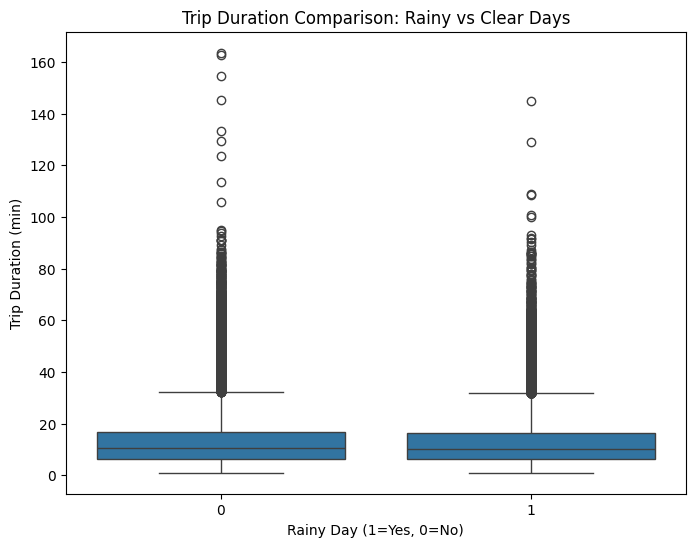

In [ ]:
# Ensure precipitation (prcp) exists and treat missing values
if "prcp" in merged_df.columns:
    merged_df["prcp"] = merged_df["prcp"].fillna(0)

    # Create rainy flag: 1 if precipitation > 0, else 0
    merged_df["rainy"] = (merged_df["prcp"] > 0).astype(int)
else:
    print("⚠️ 'prcp' column not found — cannot create rainy flag.")

print("Columns now:", merged_df.columns.tolist())
print(merged_df[["prcp", "rainy"]].head())

plt.figure(figsize=(8,6))
sns.boxplot(x="rainy", y="trip_duration_min", data=merged_df)
plt.xlabel("Rainy Day (1=Yes, 0=No)")
plt.ylabel("Trip Duration (min)")
plt.title("Trip Duration Comparison: Rainy vs Clear Days")
plt.show()


##Average Trip Duration by Temperature Zones

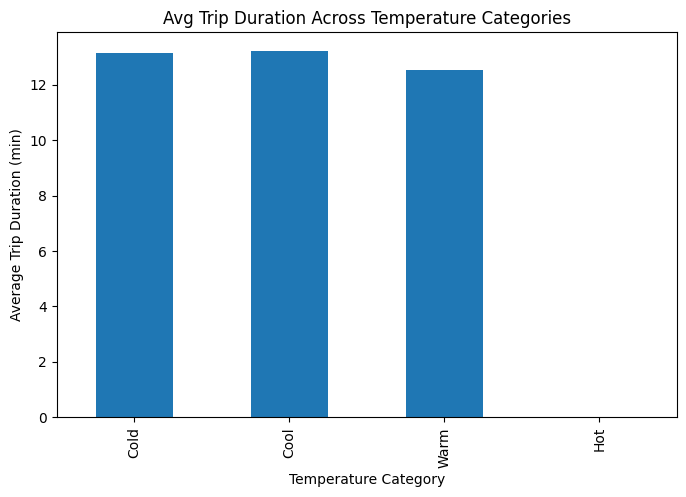

In [ ]:
merged_df["temp_bucket"] = pd.cut(merged_df["tavg"], bins=[-5,5,15,25,35],
                                  labels=["Cold","Cool","Warm","Hot"])

plt.figure(figsize=(8,5))
merged_df.groupby("temp_bucket")["trip_duration_min"].mean().plot(kind="bar")
plt.title("Avg Trip Duration Across Temperature Categories")
plt.ylabel("Average Trip Duration (min)")
plt.xlabel("Temperature Category")
plt.show()


##Weather Condition Effect on Trip Duration

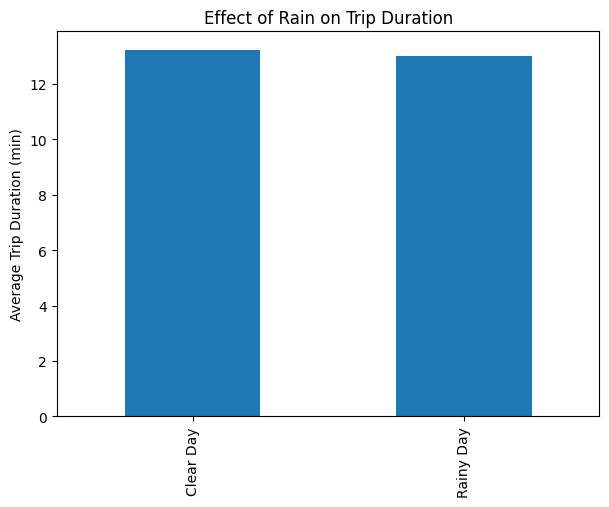

In [ ]:
weather_effect = merged_df.groupby("rainy")["trip_duration_min"].mean()
weather_effect.index = ["Clear Day", "Rainy Day"]

plt.figure(figsize=(7,5))
weather_effect.plot(kind="bar")
plt.title("Effect of Rain on Trip Duration")
plt.ylabel("Average Trip Duration (min)")
plt.show()


##Relationship Exploration

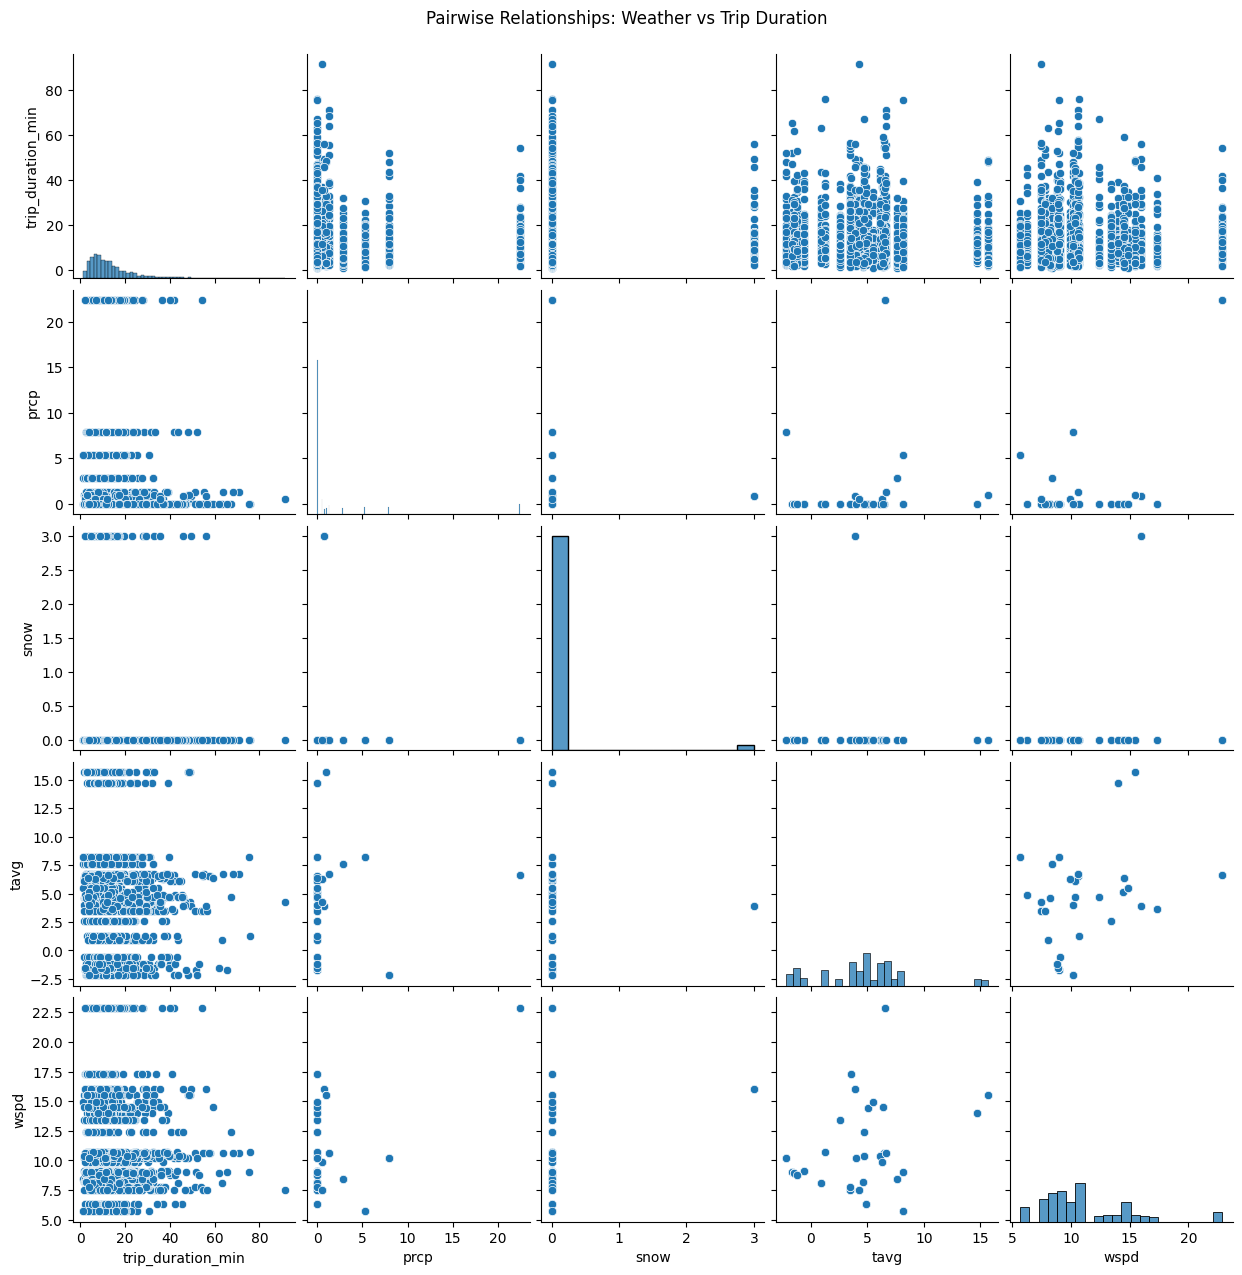

In [ ]:
sns.pairplot(merged_df[["trip_duration_min", "prcp", "snow", "tavg", "wspd"]].sample(2000))
plt.suptitle("Pairwise Relationships: Weather vs Trip Duration", y=1.02)
plt.show()


In [ ]:

# sample_frac = 0.05
# merged_df_sampled = merged_df.sample(frac=sample_frac, random_state=RANDOM_SEED).reset_index(drop=True)

# print("After sampling:", merged_df_sampled.shape)


After sampling: (314709, 36)


In [ ]:
# Sort by time for time-aware split
merged_df_sorted = merged_df_sampled.sort_values("tpep_pickup_datetime").reset_index(drop=True)

X_sorted = merged_df_sorted[feature_cols].copy()
y_sorted = merged_df_sorted["trip_duration_min"].values

# Keep only numeric columns
X_sorted = X_sorted.select_dtypes(include=[np.number]).copy()

# Drop columns that are fully NaN
X_sorted = X_sorted.dropna(axis=1, how="all").copy()

# Fill remaining NaNs with column medians
for col in X_sorted.columns:
    if X_sorted[col].isna().any():
        X_sorted[col] = X_sorted[col].fillna(X_sorted[col].median())

print("X_sorted shape:", X_sorted.shape, "y_sorted shape:", y_sorted.shape)

# Train/validation split: 80/20 by time
n = len(X_sorted)
train_size = int(0.8 * n)

X_train = X_sorted.iloc[:train_size].values
X_val   = X_sorted.iloc[train_size:].values
y_train = y_sorted[:train_size]
y_val   = y_sorted[train_size:]

print("Train size:", X_train.shape[0], "Val size:", X_val.shape[0])

# Final NaN/inf guard
X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
X_val   = np.nan_to_num(X_val,   nan=0.0, posinf=0.0, neginf=0.0)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

input_dim = X_train_scaled.shape[1]
print("Input dim:", input_dim)


X_sorted shape: (314709, 16) y_sorted shape: (314709,)
Train size: 251767 Val size: 62942
Input dim: 16


##Model Building: Linear Regression, MLP, and DNN

In [ ]:
# import tensorflow as tf

print("TF version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))

if tf.config.list_physical_devices('GPU'):
    print("✅ GPU is visible to TensorFlow.")
else:
    print("❌ No GPU visible. In Colab: Runtime → Change runtime type → GPU")


TF version: 2.19.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ GPU is visible to TensorFlow.


In [ ]:
# ⚠️ Do this once after merged_df + feature_cols are ready
sample_frac = 0.02  # 2% of data (~120k rows) – adjust if needed
merged_df = merged_df.sample(frac=sample_frac, random_state=RANDOM_SEED).reset_index(drop=True)
print("After sampling:", merged_df.shape)


After sampling: (125883, 36)


In [ ]:



def compile_and_train(model, optimizer, loss_fn,
                      X_train, y_train, X_val, y_val,
                      epochs=100, batch_size=32, verbose=0,
                      callbacks=None):
    """
    Compile Keras model, train it, and return history.
    Now supports callbacks (e.g., EarlyStopping).
    """
    model.compile(
        optimizer=optimizer,
        loss=loss_fn,
        metrics=["mae"]
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=verbose,
        callbacks=callbacks or []
    )
    return history

# ---------- EarlyStopping to avoid wasting epochs ----------

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,              # stop if no improvement for 5 epochs
    restore_best_weights=True
)

# ---------- Experiment configuration (lighter but prof-compliant) ----------

experiments = []

model_builders = {
    "Linear": build_linear_regression_model,
    "MLP":    build_mlp_model,
    "DNN":    build_dnn_model
}

# Keep all 3 models, but fewer optimizer/LR combos to keep runtime sane
optimizers_config = [
    ("Adam",   Adam),
    ("RMSprop", RMSprop)
]

learning_rates = [1e-3]      # one good LR per optimizer

EPOCHS = 40                  # with EarlyStopping, most runs will stop earlier
BATCH_SIZE = 32
LOSS_FN = "mse"              # project requires MSE; MAE tracked as metric

# ---------- Use GPU if available ----------

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    device_name = "/GPU:0"
    print("✅ Using GPU:", gpus[0])
else:
    device_name = "/CPU:0"
    print("⚠️ No GPU found, training on CPU.")

# ---------- Main experiment loop ----------

with tf.device(device_name):
    for model_name, builder in model_builders.items():
        for opt_name, opt_class in optimizers_config:
            for lr in learning_rates:
                print(f"\n=== Training {model_name} with {opt_name}, lr={lr} ===")
                model = builder(input_dim)
                optimizer = opt_class(learning_rate=lr)

                history = compile_and_train(
                    model,
                    optimizer,
                    LOSS_FN,
                    X_train_scaled,
                    y_train,
                    X_val_scaled,
                    y_val,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=1,              # show per-epoch progress
                    callbacks=[early_stop]  # <-- EarlyStopping
                )

                final_train_loss = history.history["loss"][-1]
                final_val_loss   = history.history["val_loss"][-1]
                final_train_mae  = history.history["mae"][-1]
                final_val_mae    = history.history["val_mae"][-1]

                experiments.append({
                    "model": model_name,
                    "optimizer": opt_name,
                    "lr": lr,
                    "final_train_loss": final_train_loss,
                    "final_val_loss": final_val_loss,
                    "final_train_mae": final_train_mae,
                    "final_val_mae": final_val_mae,
                    "history": history,
                    "trained_model": model
                })

print("\nTotal experiments:", len(experiments))


✅ Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

=== Training Linear with Adam, lr=0.001 ===
Epoch 1/40
7868/7868 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 190.3887 - mae: 11.2727 - val_loss: 69.3666 - val_mae: 6.6889
Epoch 2/40
7868/7868 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - loss: 43.7392 - mae: 4.8552 - val_loss: 21.4065 - val_mae: 2.9118
Epoch 3/40
7868/7868 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 18.6620 - mae: 2.7029 - val_loss: 19.3151 - val_mae: 2.8090
Epoch 4/40
7868/7868 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 17.5676 - mae: 2.6450 - val_loss: 18.7537 - val_mae: 2.7806
Epoch 5/40
7868/7868 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 17.2336 - mae: 2.6304 - val_loss: 18.5044 - val_mae: 2.7709
Epoch 6/40
7868/7868 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 17.0990 - mae: 2.6288 - val_loss: 18.3759 - val_mae: 2.7686
Epoch 7/40
7868/7868 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 17.0317 - mae: 2.6312 - val_loss: 18.3040 - val_mae: 2.7695
Epoch 8/40
786

In [ ]:
results_df = pd.DataFrame([
    {
        "Model": exp["model"],
        "Optimizer": exp["optimizer"],
        "LR": exp["lr"],
        "Train_MSE": exp["final_train_loss"],
        "Val_MSE": exp["final_val_loss"],
        "Train_MAE": exp["final_train_mae"],
        "Val_MAE": exp["final_val_mae"],
    }
    for exp in experiments
])

results_df = results_df.sort_values("Val_MAE").reset_index(drop=True)
display(results_df)


,Model,Optimizer,LR,Train_MSE,Val_MSE,Train_MAE,Val_MAE
0,DNN,RMSprop,0.001,0.496525,0.318554,0.129779,0.190587
1,MLP,RMSprop,0.001,0.842136,0.693499,0.171442,0.297137
2,MLP,Adam,0.001,0.707925,0.598042,0.250946,0.371303
3,DNN,Adam,0.001,0.597117,0.664721,0.254379,0.468893
4,Linear,RMSprop,0.001,18.368851,17.925951,2.646364,2.736764
5,Linear,Adam,0.001,17.989542,18.206800,2.679614,2.794612


In [ ]:
import os

# Directory to store saved models
SAVE_DIR = "content/saved_models"
os.makedirs(SAVE_DIR, exist_ok=True)

# Pick best (lowest Val_MAE) per model type: Linear, MLP, DNN
best_by_model = {}

for exp in experiments:
    model_name = exp["model"]            # 'Linear', 'MLP', or 'DNN'
    val_mae = exp["final_val_mae"]

    if model_name not in best_by_model or val_mae < best_by_model[model_name]["final_val_mae"]:
        best_by_model[model_name] = exp

print("Best config per model type:")
for name, exp in best_by_model.items():
    print(f"  {name}: optimizer={exp['optimizer']}, lr={exp['lr']}, Val_MAE={exp['final_val_mae']:.4f}")

# Save the 3 best models
for name, exp in best_by_model.items():
    model = exp["trained_model"]
    opt_name = exp["optimizer"]
    lr = exp["lr"]

    # Nice, descriptive filename
    filename = f"{name}_{opt_name}_lr{lr:.0e}.keras"   # e.g. 'MLP_RMSprop_lr1e-03.keras'
    filepath = os.path.join(SAVE_DIR, filename)

    model.save(filepath)
    print(f"✅ Saved {name} model to: {filepath}")


Best config per model type:
  Linear: optimizer=RMSprop, lr=0.001, Val_MAE=2.7368
  MLP: optimizer=RMSprop, lr=0.001, Val_MAE=0.2971
  DNN: optimizer=RMSprop, lr=0.001, Val_MAE=0.1906
✅ Saved Linear model to: content/saved_models/Linear_RMSprop_lr1e-03.keras
✅ Saved MLP model to: content/saved_models/MLP_RMSprop_lr1e-03.keras
✅ Saved DNN model to: content/saved_models/DNN_RMSprop_lr1e-03.keras


In [ ]:
import shutil
import os
from google.colab import files

def zip_and_download(folder_path):
    if not os.path.exists(folder_path):
        print(f"❌ Folder not found: {folder_path}")
        return

    zip_filename = folder_path.rstrip("/").split("/")[-1] + ".zip"  # e.g., saved_models.zip
    shutil.make_archive(zip_filename.replace(".zip",""), 'zip', folder_path)

    print(f"📦 Zipped successfully: {zip_filename}")
    files.download(zip_filename)

# 👉 Use your path here:
zip_and_download("content/saved_models")


📦 Zipped successfully: saved_models.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Best model configuration:
  Model:     DNN
  Optimizer: RMSprop
  LR:        0.001
  Val_MAE:   0.1905871331691742
  Val_MSE:   0.31855350732803345


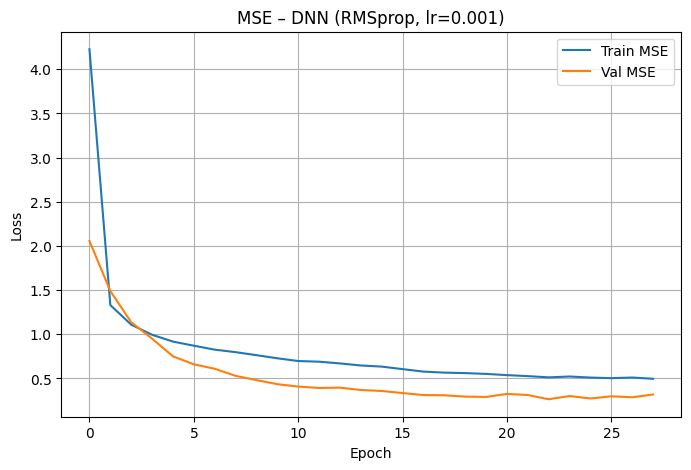

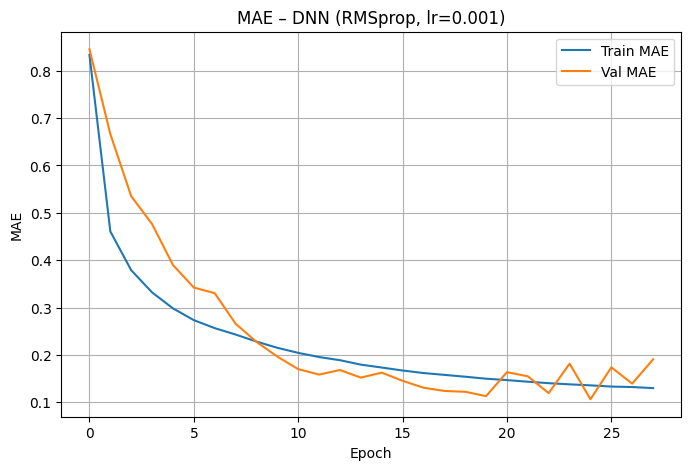

In [ ]:
best_exp = min(experiments, key=lambda e: e["final_val_mae"])

print("Best model configuration:")
print("  Model:    ", best_exp["model"])
print("  Optimizer:", best_exp["optimizer"])
print("  LR:       ", best_exp["lr"])
print("  Val_MAE:  ", best_exp["final_val_mae"])
print("  Val_MSE:  ", best_exp["final_val_loss"])

history = best_exp["history"]

plt.figure(figsize=(8,5))
plt.plot(history.history["loss"], label="Train MSE")
plt.plot(history.history["val_loss"], label="Val MSE")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"MSE – {best_exp['model']} ({best_exp['optimizer']}, lr={best_exp['lr']})")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history["mae"], label="Train MAE")
plt.plot(history.history["val_mae"], label="Val MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title(f"MAE – {best_exp['model']} ({best_exp['optimizer']}, lr={best_exp['lr']})")
plt.legend()
plt.grid(True)
plt.show()
